In [1]:
import os

os.chdir("../")

import pandas as pd
import numpy as np
import geopandas as gpd
import folium
import osmnx as ox
import requests
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import shape
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Overpass API for OpenStreetMap

In [2]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area[name = "Washington"];
(node["amenity"="restaurant"](area);
 way["amenity"="restaurant"](area);
 rel["amenity"="restaurant"](area);
);
out center;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()

In [3]:
rest_dict = {
    "id": [],
    "lat": [],
    "lon": [],
    "name": []
}
for ele in data["elements"]:
    if "name" in ele["tags"]:
        rest_dict["id"].append(ele["id"])
        rest_dict["lat"].append(ele["lat"])
        rest_dict["lon"].append(ele["lon"])
        rest_dict["name"].append(ele["tags"]["name"])

In [4]:
dc_rest = pd.DataFrame(rest_dict)
gdf = gpd.GeoDataFrame(dc_rest,
                       geometry=gpd.points_from_xy(dc_rest.lon, dc_rest.lat),
                       crs="EPSG:4326")

In [5]:
## Filter out the resturants in Washington State
hsipath = os.getcwd() + "/data/hsi/Heat_Sensitivity_Exposure_Index.shp"
dc_geometry = gpd.read_file(hsipath).dissolve()["geometry"][0]

In [6]:
gdf = gdf[gdf.within(dc_geometry)].reset_index().drop("index", axis=1)
gdf.head(5)

,id,lat,lon,name,geometry
0,388247153,38.945050,-77.096330,Millie’s,POINT (-77.09633 38.94505)
1,462011947,38.909472,-77.045582,Al Tiramisu,POINT (-77.04558 38.90947)
2,462044729,38.909474,-77.045687,Bangkok Thai Dining,POINT (-77.04569 38.90947)
3,486343600,38.899625,-77.020706,New Big Wong,POINT (-77.02071 38.89963)
4,486343622,38.899978,-77.020505,Jackey Cafe,POINT (-77.02050 38.89998)


## Route (TBD)

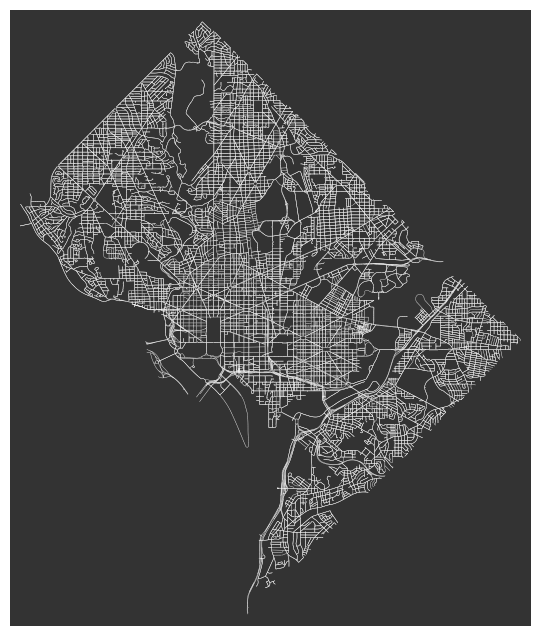

In [7]:
G = ox.graph_from_place("District of Columbia, USA",
                        network_type="drive",
                        simplify=False)
fig, ax = ox.plot_graph(
    G,
    show=False,
    close=False,
    bgcolor="#333333",
    edge_color="w",
    edge_linewidth=0.3,
    node_size=0,
)

In [8]:
orig = gdf[gdf.name == "La Vie"]
dest = gdf[gdf.name == "Toki Underground"]
orig_node = ox.distance.nearest_nodes(G, orig.lon, orig.lat)
dest_node = ox.distance.nearest_nodes(G, dest.lon, dest.lat)

route = ox.shortest_path(G, orig_node, dest_node, weight="length")
route

[[3659216719,
  5180966153,
  5736733180,
  3000233162,
  5736733178,
  3000233170,
  3000233153,
  2994970597,
  622720635,
  3000233148,
  9130878047,
  3000233165,
  2994970601,
  3006128164,
  4977424909,
  49791573,
  5553643998,
  9363044089,
  4977416069,
  3000324014,
  3005643154,
  4977416065,
  3000324031,
  3000324165,
  9130918495,
  3000324002,
  3000324011,
  8427531401,
  4240051851,
  3000324144,
  49802547,
  49796861,
  2791548183,
  49754051,
  49802546,
  49779841,
  8459956976,
  49802545,
  9130918464,
  5171903721,
  3748536020,
  3748536017,
  5171896417,
  49828677,
  49885249,
  5171896405,
  49855611,
  2791594419,
  3005815346,
  3005815345,
  49855616,
  8384245596,
  3010649395,
  8417966680,
  49855619,
  3010696905,
  3010698045,
  2791594416,
  49757901,
  2791594414,
  8480398598,
  8480398605,
  291401079,
  9130143760,
  641964879,
  641964881,
  8480334631,
  2791548448,
  8412674850,
  8412861329,
  8412802564,
  2791548441,
  49742491,
  27915484

In [9]:
# Don't why directly calling route would return a nested list
# So decided to turn it to a list
route = route[0]

In [10]:
ox.plot_route_folium(G,
                     route,
                     popup_attribute='name',
                     tiles='CartoDB dark_matter')